# Methods of drawing circular apertures

* circle equation
* circle equation + super sampling anti-aliasing
* inverse Fourier transform of Jinc function
* inverse Fourier transform of Jinc function with an anti-ringing filter

In [14]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
plt.style.use('../user.mplstyle')

import sys
sys.path.append('../')

import LCT_functions as lctf
import optical_functions as of

# Using the circle equation and numpy

In [336]:
def circ_tophat_2D(xs, ys=None, r=1, x0=0, y0=0):
    '''
    computes the analytical solution for the fft of circ tophat.
    Inverting the fft gives back the circ tophat.
    This is a way better way of defining a circ tophat than the 
    implicit equation since this one has infinite support for r,x0,y0.
    
    r : radius of top hat
    x0 : offset of tophat center to the right
    y0 : offset of tophat center up
    
    offsets can be made negative to go in the other direction
    '''

    if ys is None:
        ys = xs

    Nx = len(xs)
    Ny = len(ys)
    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    rs = np.sqrt(np.add.outer((ys-y0)**2, (xs-x0)**2))

    circ = np.ones([Ny, Nx])
    circ[rs > r] = 0
    
    return circ

In [337]:
xs = np.linspace(-1, 1, 71)
ys = np.linspace(-1, 1, 70)

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

r = 0.43
c = circ_tophat_2D(xs, ys, r, x0=0.123, y0=0.345)
i = np.sum(c)
i2 = np.pi*r**2

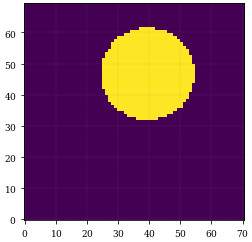

In [338]:
plt.imshow(c, interpolation='nearest')

In [339]:
# compute the empirircal centroids

xc = np.sum(c*xs[None,:])/i
yc = np.sum(c*ys[:,None])/i
print(xc, yc)

0.12196707986181667 0.3452903704619952


In [340]:
# difference between input and empirical centroids

print(xc-x0, yc-y0)

-0.0010329201381833325 0.0002903704619952041


The circle equation produces a jaggy pixelated map and the centroid of the aperture doesn't agree with the offests we put in

# Try brute force super sampling anti-aliasing to get a smoother circle

In [341]:
ss = 8 # render at 8 times higher resolution

xs = np.linspace(-1, 1, 71)
ys = np.linspace(-1, 1, 70)

xs_ss = np.linspace(-1, 1, 71*ss)
ys_ss = np.linspace(-1, 1, 70*ss)

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

r = 0.43
c = circ_tophat_2D(xs_ss, ys_ss, r, x0=0.123, y0=0.345)
i = np.sum(c)

In [342]:
# downscale back to the original dimensions
# I might be doing this wrong because array reshaping is a weird way of doing it
# you can use proper downscaling methods instead but the point is to show that this is possible

c_sx = np.sum(c.reshape(70, ss, 71*ss), axis=1)/ss
c_ss = np.sum(c_sx.reshape(70, 71, ss), axis=2)/ss
i_ss = np.sum(c_ss)

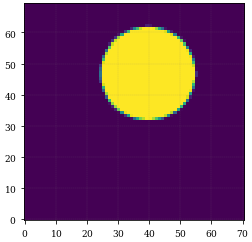

In [343]:
plt.imshow(c_ss, interpolation='nearest')

In [344]:
# compute the empirircal centroids

xc_ss = np.sum(c_ss*xs[None,:])/i_ss
yc_ss = np.sum(c_ss*ys[:,None])/i_ss
print(xc_ss, yc_ss)

0.12459096777397084 0.34931591381924615


In [284]:
# difference between input and empirical centroids

print(xc_ss-x0, yc_ss-y0)

0.0015909677739708444 0.0043159138192461755


the circle looks less jaggy but the centroids are still not lining up with the input

now for (in my opinion) the best way to draw a circle

# Sample the circle as a Jinc in Fourier space and inverse Fourier transform to get back to the circle

In [322]:
def gaussian_wn(N, sigma=0.17):
    '''
    1D gaussian window function
    '''
    ns = np.arange(N)/(N-1) - 0.5
    out = np.exp(-(ns/sigma)**2)
    return out

def gaussian_wn2(N, M, sigma=0.17):
    '''
    2D gaussian window function
    '''
    g1 = gaussian_wn(N, sigma)
    g2 = gaussian_wn(M, sigma)
    return np.outer(g2, g1)

@np.vectorize
def jinc(x):
    '''
    The analytical solution to the Fourier transform of a circle
    '''
    if not x:
        out = 1.0
    else:
        out = 2*scipy.special.jv(1, x)/x
    return out

In [323]:
def dft_xs_scaling(N, dx=1, lam=1):
    '''Scaling factor that turns the continous Fourier transfrom into the DFT'''
    s = lam/np.abs(N*dx**2)
    return s

def ixft2(x, norm=True):
    '''
    A fast way to compute the centered DFT by using the FFT and the Fourier shift 
    theorem to center the FFT kernel.
    '''
    x = np.asarray(x)
    M,N = np.shape(x)
    ns = np.arange(N)
    ms = np.arange(M)
    a0n = np.exp(1j*np.pi*(N-1)**2/2/N)
    a0m = np.exp(1j*np.pi*(M-1)**2/2/M)
    Sn = np.exp(-1j*np.pi*(N-1)*ns/N)[None, :]
    Sm = np.exp(-1j*np.pi*(M-1)*ms/M)[:, None]
    X = a0n*a0m*Sm*Sn*np.fft.ifft2(Sm*Sn*x)
    if norm:
        X *= np.sqrt(N*M)
    return X

def circ_tophat_fourier_2D(xs, ys=None, r=1, x0=0, y0=0, window_function=gaussian_wn2):
    '''
    computes the analytical solution for the fft of circ tophat.
    Inverting the fft gives back the circ tophat.
    This is a way better way of defining a circ tophat than the 
    implicit equation since this one has infinite support for r,x0,y0.
    
    r : radius of top hat
    x0 : offset of tophat center to the right
    y0 : offset of tophat center up
    
    offsets can be made negative to go in the other direction
    '''

    if ys is None:
        ys = xs

    Nx = len(xs)
    Ny = len(ys)
    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    fxsc = dft_xs_scaling(Nx ,dx)
    fysc = dft_xs_scaling(Ny, dy)

    # compute the fourier transform of coordinate translations so
    # that we can reposition the circle in the array
    ft_xshift = np.exp(-1j*xs*fxsc*x0*np.pi*2)
    ft_yshift = np.exp(-1j*ys*fysc*y0*np.pi*2)
    ft_shift = np.multiply.outer(ft_yshift, ft_xshift)

    # the norm makes tophat height unity
    norm = np.pi*r**2/(dx*dy*np.sqrt(Nx*Ny))

    # compute the samples of the Jinc function
    rs = np.sqrt(np.add.outer((ys*fysc)**2, (xs*fxsc)**2))
    somb2 = jinc(rs*np.pi*r*2)
    
    # apply normalization and fourier shifts to translate the origin of the circle 
    somb2 = somb2*ft_shift*norm
    
    # apply anti-ringing filter
    if window_function is not None:
        wn_fn = window_function(Nx, Ny)
        somb2 = wn_fn*somb2
    
    return np.real(ixft2(somb2))

In [324]:
xs = np.linspace(-1, 1, 71)
ys = np.linspace(-1, 1, 70)

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

x0 = 0.123
y0 = 0.345

r = 0.43

# disable the default window function
c2 = circ_tophat_fourier_2D(xs, ys, r, x0=x0, y0=y0, window_function=None)
i2 = np.sum(c2)

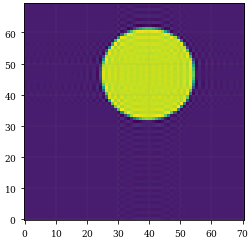

In [325]:
plt.imshow(c2, interpolation='nearest')

In [326]:
# compute the empirircal centroids

xc2 = np.sum(c2*xs[None,:])/i2
yc2 = np.sum(c2*ys[:,None])/i2
print(xc2, yc2)

0.12305020676728304 0.34495584808873564


In [327]:
# difference between input and empirical centroids

print(xc2-x0, yc2-y0)

5.0206767283039744e-05 -4.415191126433404e-05


The centroids are more accurate but the circle has a lot of ringing artifacts. That's common for Fourier space. We can remove them by adding a window function.

# Fourier sampled circle but with an anti-ringing window function

In [328]:
xs = np.linspace(-1, 1, 71)
ys = np.linspace(-1, 1, 70)

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

x0 = 0.123
y0 = 0.345

r = 0.43

# window function is used by default in the function
c2 = circ_tophat_fourier_2D(xs, ys, r, x0=x0, y0=y0)
i2 = np.sum(c2)

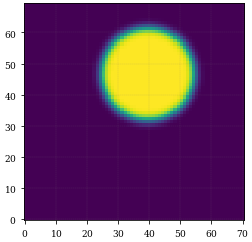

In [329]:
plt.imshow(c2, interpolation='nearest')

In [330]:
# compute the empirircal centroids

xc2 = np.sum(c2*xs[None,:])/i2
yc2 = np.sum(c2*ys[:,None])/i2
print(xc2, yc2)

0.12300000476524559 0.344999995601978


In [331]:
# difference between input and empirical centroids

print(xc2-x0, yc2-y0)

4.765245587012856e-09 -4.39802194662775e-09


The centroids are now very accurate but the circle looks a bit blurrier. That's because of the window function.

# You can make the fourier circular aperture less blurry by using a higher resolution

In [332]:
xs = np.linspace(-1, 1, 301)
ys = np.linspace(-1, 1, 300)

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

x0 = 0.123
y0 = 0.345

r = 0.43
c3 = circ_tophat_fourier_2D(xs, ys, r, x0=x0, y0=y0)
i3 = np.sum(c3)

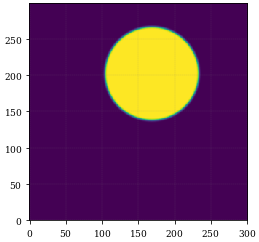

In [333]:
plt.imshow(c3, interpolation='nearest')

In [334]:
# compute the empirircal centroids

xc3 = np.sum(c3*xs[None,:])/i3
yc3 = np.sum(c3*ys[:,None])/i3
print(xc3, yc3)

0.12299999970648255 0.34499999992393854


In [335]:
# difference between input and empirical centroids

print(xc3-x0, yc3-y0)

-2.935174464591128e-10 -7.60614349282207e-11


a very high quality circle that we can resize and reposition as much as we want